In [1]:
from base import *
from ann import *
from arbol import *
from sklearn.model_selection import train_test_split

1. Capacidad de modelado: Entrene redes neuronales para resolver el problema de clasificación de las espirales anidadas que creamos en el TP 0. Use un número creciente de neuronas en la capa intermedia: 2, 10, 20, 40. Valores posibles para los demás parámetros de entrenamiento: learning rate 0.1, momentum 0.9, 600 datos para ajustar los modelos (20% de ese conjunto separarlo al azar para conjunto de validación), 2000 para testear, 1000 evaluaciones del entrenamiento, cada una de 20 épocas. Para cada uno de los cuatro modelos obtenidos, graficar en el plano xy las clasificaciones sobre el conjunto de test. Comentar.

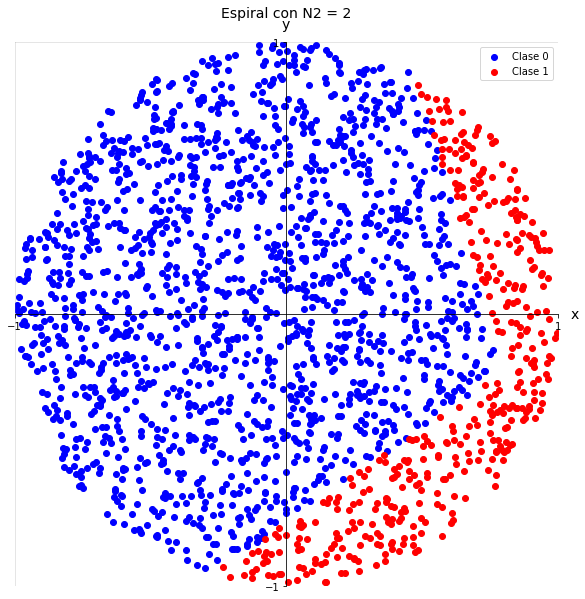

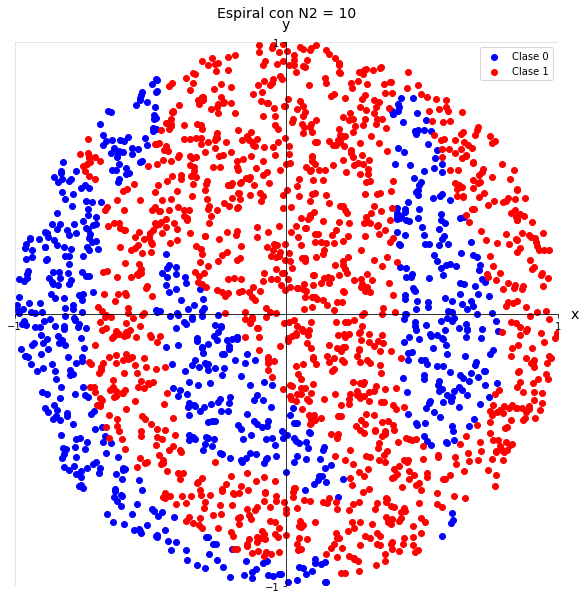

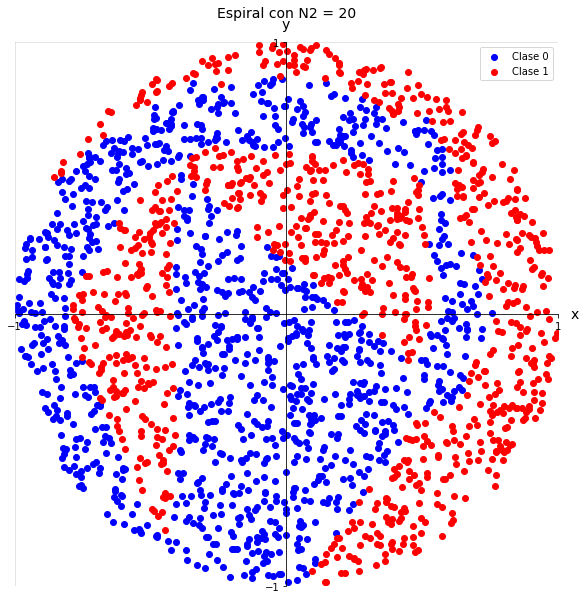

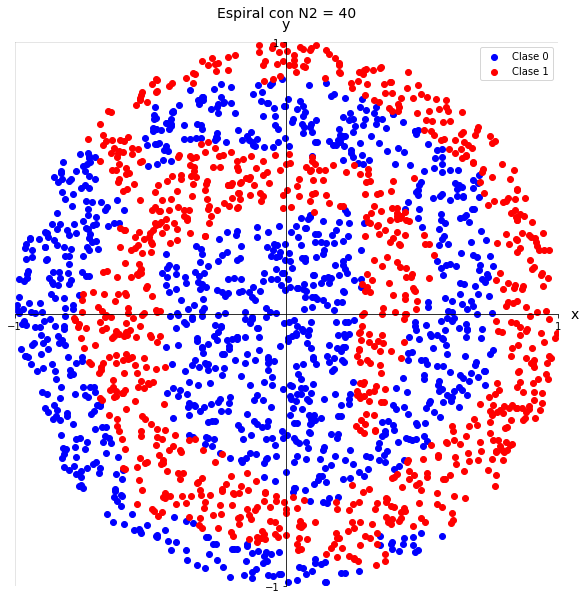

In [2]:
def ejercicio_uno():
  N2_values = [2, 10, 20, 40]
  learning_rate = 0.1
  momentum = 0.9
  epocas = 20
  evaluaciones = 1000

  df_train_val = GeneradorDFEspiral(600, 1).generar_puntos_curva()
  X_train_val, y_train_val = df_train_val[[0, 1]], df_train_val['Clase']
  X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=0)

  df_test = GeneradorDFEspiral(2000, 1).generar_puntos_curva()
  X_test, y_test = df_test[[0,1]], df_test['Clase']

  for N2 in N2_values:
    mlp = MLP(epocas, learning_rate, momentum, N2)
    best_red, _, _, _ = entrenar_red(mlp.clasif, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test)

    predict_test = best_red.predict(X_test)
    df_predict = df_test.copy(deep=True)
    df_predict['Clase'] = predict_test

    GraficadorDF(df_predict).graph_puntos(titulo="Espiral con N2 = " + str(N2))

ejercicio_uno()

Los resultados obtenidos para este problema son notablemente peores que los dados a partir de los árboles de decisión, siendo el espiral con N2=40 el que más intenta asemejarse a uno.

---

2. Mínimos locales: 
 - Baje el dataset dos-elipses de la descargas. 
 - Realice varios entrenamientos con los siguientes parámetros: 6 neuronas en la capa intermedia, 500 patrones en el training set, de los cuales 400 se usan para entrenar y 100 para validar el modelo (sacados del .data), 2000 patrones en el test set (del .test), 300 evaluaciones del entrenamiento, cada una de 50 épocas. 
 - Pruebe distintos valores de momentum y learning-rate (valores usuales son 0, 0.5, 0.9 para el momentum y 0.1, 0.01, 0.001 para el learning-rate, pero no hay por qué limitarse a esos valores, para tratar de encontrar el mejor mínimo posible de la función error. El valor que vamos a usar es el promedio de 10 entrenamientos iguales, dado que los entrenamientos incorporan el azar. Como guía, con los parámetros dados, hay soluciones entre 5% y 6% de error en test, y tal vez mejores. 
 - Confeccione una tabla con los valores usados para los parámetros y el resultado en test obtenido (la media de las 10 ejecuciones). 
 - Haga una gráfica de mse de train, validación y test en función del número de épocas para los valores seleccionados (los mejores valores de eta y alfa). 



In [2]:
from math import inf

def dfs():
  dos_e_dfs = GeneradorDFCSV(filename="dos_elipses")

  # Se toma una muestra aleatoria de la mitad de df_data ya que el dataset cuenta con 1000 filas. 
  df_train_val = dos_e_dfs.df_data.sample(frac=0.5)
  X_train_val, y_train_val = df_train_val[[0, 1]], df_train_val['Clase']
  X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=0)

  df_test = dos_e_dfs.df_test
  X_test, y_test = df_test[[0, 1]], df_test['Clase']

  return X_train, X_val, y_train, y_val, X_test, y_test

def ejercicio_dos():
  X_train, X_val, y_train, y_val, X_test, y_test = dfs()
  N2 = 6
  evaluaciones = 300
  epocas = 50

  eta_values = [0.1, 0.01, 0.001]   # learning rate
  alfa_values = [0, 0.5, 0.9]       # momentum

  tabla = []
  best_mean_test_error = inf

  for (eta, alfa) in [(e,a) for e in eta_values for a in alfa_values]:
    for i in range(10):
      error_train = []
      error_val = []
      error_test = []

      mlp = MLP(epocas, eta, alfa, N2)
      test_entrenado, error_train_data, error_val_data, error_test_data = entrenar_red(mlp.clasif, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test)

      error_train.append(error_train_data)
      error_val.append(error_val_data)
      error_test.append(error_test_data)

    error_train = np.asarray(error_train)
    error_val = np.asarray(error_val)
    error_test = np.asarray(error_test)

    mean_train_error = error_train.mean(axis=0)
    mean_val_error = error_val.mean(axis=0)
    mean_test_error = error_test.mean(axis=0)

    min_val_error = np.min(mean_val_error)
    index_min_val_error = np.where(mean_val_error == min_val_error)[0][0]

    min_mean_test_error = mean_test_error[index_min_val_error]

    if min_mean_test_error < best_mean_test_error:
      best_mean_test_error = min_mean_test_error
      best_eta = eta
      best_alfa = alfa
      best_train_error = np.copy(mean_train_error)
      best_val_error = np.copy(mean_val_error)
      best_test_error = np.copy(mean_test_error)
      best_test_entrenado = np.copy(test_entrenado)

    #print(mean_train_error)
    tabla.append([eta, alfa, min_mean_test_error])

  errores = []
  for i in range(evaluaciones):
    errores.append([best_train_error[i], i * epocas, "Error train"])
    errores.append([best_val_error[i], i * epocas, "Error validación"])
    errores.append([best_test_error[i], i * epocas, "Error test"])

  df_errores = pd.DataFrame(errores, columns=["Error", "Épocas", "Clase"])
  df_tabla = pd.DataFrame(tabla, columns=["eta", "alfa", "Media error test"])
  #df_train = pd.DataFrame(best_red, columns=[0,1,'Clase'])

  test_frame = {0: X_test[0], 1: X_test[1], 'Clase': best_test_entrenado}

  return test_frame, df_errores, df_tabla, best_eta, best_alfa, best_mean_test_error


In [3]:
prediccion_test, df_errores, df_tabla, best_eta, best_alfa, best_mean_test_error = ejercicio_dos()

In [4]:
df_train = pd.DataFrame(prediccion_test, columns=[0,1,'Clase'])
#print(df_train)
df_train.to_csv("./datasets/ej2/df_train.csv", index=False)

In [5]:
print(f"Mejor learning rate: {best_eta}; mejor momentum: {best_alfa}; mejor promedio de error en test: {best_mean_test_error}")
df_tabla

Mejor learning rate: 0.1; mejor momentum: 0.9; mejor promedio de error en test: 0.09250000000000003


,eta,alfa,Media error test
0,0.100,0.0,0.1915
1,0.100,0.5,0.1640
2,0.100,0.9,0.0925
3,0.010,0.0,0.2435
4,0.010,0.5,0.1980
5,0.010,0.9,0.1380
6,0.001,0.0,0.2435
7,0.001,0.5,0.2435
8,0.001,0.9,0.2435


In [6]:
#df_errores.to_csv("./datasets/ej2/df_errores.csv")
#df_tabla.to_csv("./datasets/ej2/df_tabla.csv")

def graph_errores(error_df: pd.DataFrame, referencia):
  fig, ax = plt.subplots(figsize=(15, 10))
  clases = pd.unique(error_df['Clase'])

  for c in clases:
    df = error_df[error_df['Clase'] == c]
    df = df.groupby(referencia).mean().reset_index()

    switch={
      "Error train": ":",
      "Error validación": "-.",
      "Error test": "-",
      "Traindiagonal": "-",
      "Trainparalelo": "-",
      "Testdiagonal": "-",
      "Testparalelo": "-"
    }
    
    plt.plot(df[referencia], df['Error'], linestyle=switch.get(c, ":"))

  ax.grid(which='both', color='grey', linewidth=1, linestyle='-', alpha=0.2)

  plt.legend(clases, ncol = 4)
  plt.xlabel(referencia, size=14, labelpad=20)
  plt.ylabel('Error', size=14, labelpad=20)


In [ ]:

def graph_errores(error_df: pd.DataFrame, referencia):
  fig, ax = plt.subplots(figsize=(15, 10))
  clases = pd.unique(error_df['Clase'])

  for c in clases:
    df = error_df[error_df['Clase'] == c]
    df = df.groupby(referencia).mean().reset_index()

    switch={
      "Error train": ":",
      "Error validación": "-.",
      "Error test": "-",
      "Traindiagonal": "-",
      "Trainparalelo": "-",
      "Testdiagonal": "-",
      "Testparalelo": "-"
    }
    
    plt.plot(df[referencia], df['Error'], linestyle=switch.get(c, ":"))

  ax.grid(which='both', color='grey', linewidth=1, linestyle='-', alpha=0.2)

  plt.legend(clases, ncol = 4)
  plt.xlabel(referencia, size=14, labelpad=20)
  plt.ylabel('Error', size=14, labelpad=20)


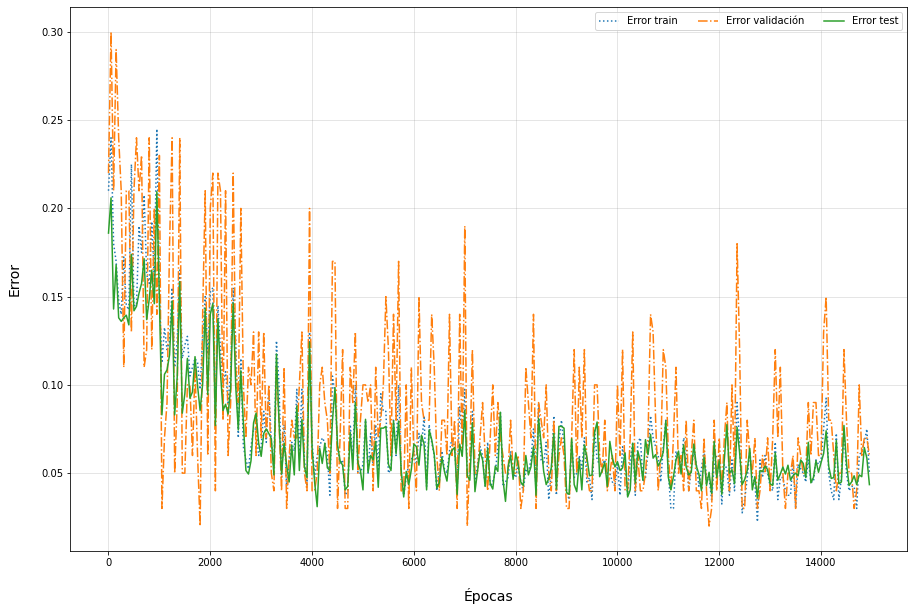

In [23]:
graph_errores(df_errores, referencia='Épocas')

Luego de entrenar todas las redes con todas las combinaciones de learning rate y momentum posibles, se obtuvo que el mejor learning rate fue de 0.1 y el mejor momentum de 0.9, cuyo promedio de error de tests fue 0.0855 (el menor de todos los calculados). También se pudo verificar que los valores de error de test oscilan entre 0.05 (5%) y 0.06 (6%) como se especificaba en la consigna.

Los valores de error de test y entrenamiento parecen mantenerse cercanos, por lo cual podríamos afirmar que no se produce sobreajuste. 

---

3. Regularización: 
 - Baje el dataset Ikeda. 
 - Realice varios entrenamientos usando el 95% del archivo .data para entrenar, y el resto para validar. Realice otros entrenamientos cambiando la relación a 75%-25%, y a 50%-50%. En cada caso seleccione un resultado que considere adecuado, y genere gráficas del mse en train, validación y test. Comente sobre los resultados. 
 - Los otros parámetros para el entrenamiento son: learning rate 0.01, momentum 0.9, 2000 datos para testear, 400 evaluaciones del entrenamiento, cada una de 50 épocas, 30 neuronas en la capa oculta.

In [11]:
def get_dfs(nombre: str, val_size: float, col_names):
  dos_e_dfs = GeneradorDFCSV(filename=nombre, custom=True, delim_whitespace=True, skipinitialspace=True, names=col_names)

  df_train_val = dos_e_dfs.df_data
  #print(df_train_val)
  X_train_val, y_train_val = df_train_val[col_names[:-1]], df_train_val[col_names[-1]]
  X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, random_state=0)

  df_test = dos_e_dfs.df_test
  X_test, y_test = df_test[col_names[:-1]], df_test[col_names[-1]]

  return X_train, X_val, y_train, y_val, X_test, y_test

In [18]:
def ejercicio_tres():
  N2 = 6
  evaluaciones = 400
  epocas = 50
  eta = 0.01   # learning rate
  alfa = 0.9   # momentum

  val_sizes = [0.05, 0.25, 0.5]

  col_names = list(range(5)) + ['Value']

  for val_size in val_sizes:
    error_train = []
    error_val = []
    error_test = []

    X_train, X_val, y_train, y_val, X_test, y_test = get_dfs('ikeda', val_size, col_names)

    mlp = MLP(epocas, eta, alfa, N2)
    _, error_train_data, error_val_data, error_test_data = entrenar_red(mlp.regr, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test)

    error_train.append(error_train_data)
    error_val.append(error_val_data)
    error_test.append(error_test_data)

    errores = []
    for i in range(evaluaciones):
      errores.append([error_train_data[i], i * epocas, "Error train"])
      errores.append([error_val_data[i], i * epocas, "Error validación"])
      errores.append([error_test_data[i], i * epocas, "Error test"])

    df_errores = pd.DataFrame(errores, columns=["Error", "Épocas", "Clase"])

    print(f"Errores con {(1-val_size)*100}% entrenamiento y {val_size * 100}% validación")
    graph_errores(df_errores, referencia='Épocas')

Errores con 95.0% entrenamiento y 5.0% validación
Errores con 75.0% entrenamiento y 25.0% validación
Errores con 50.0% entrenamiento y 50.0% validación


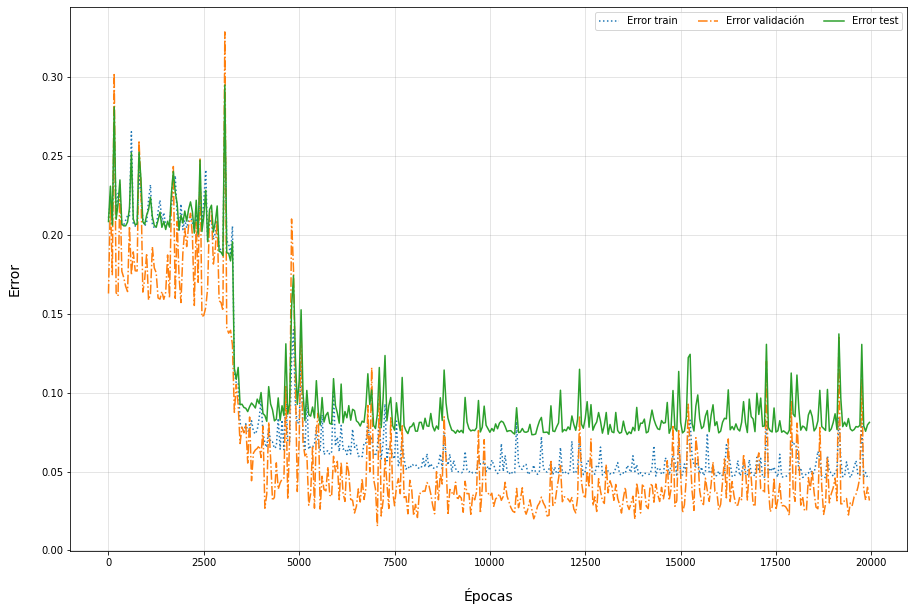

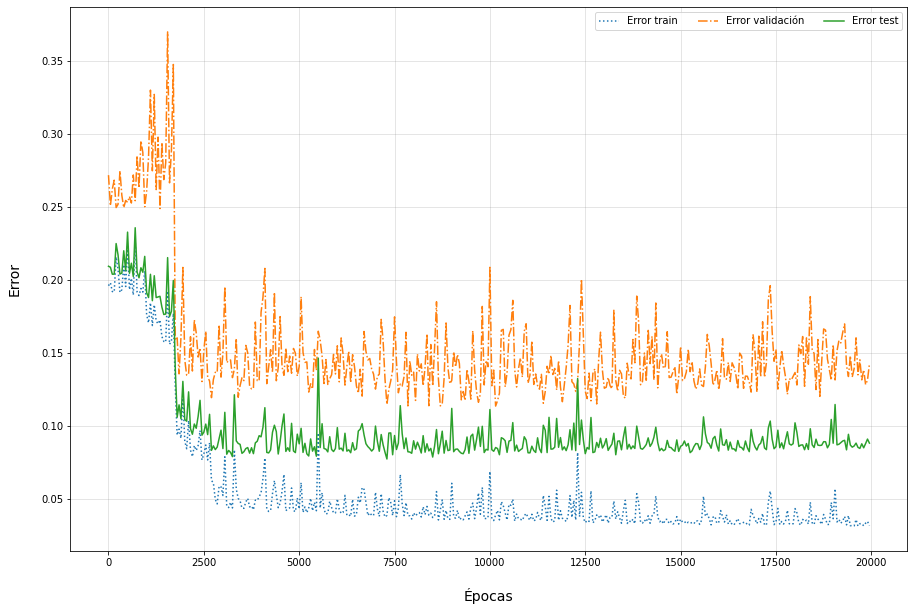

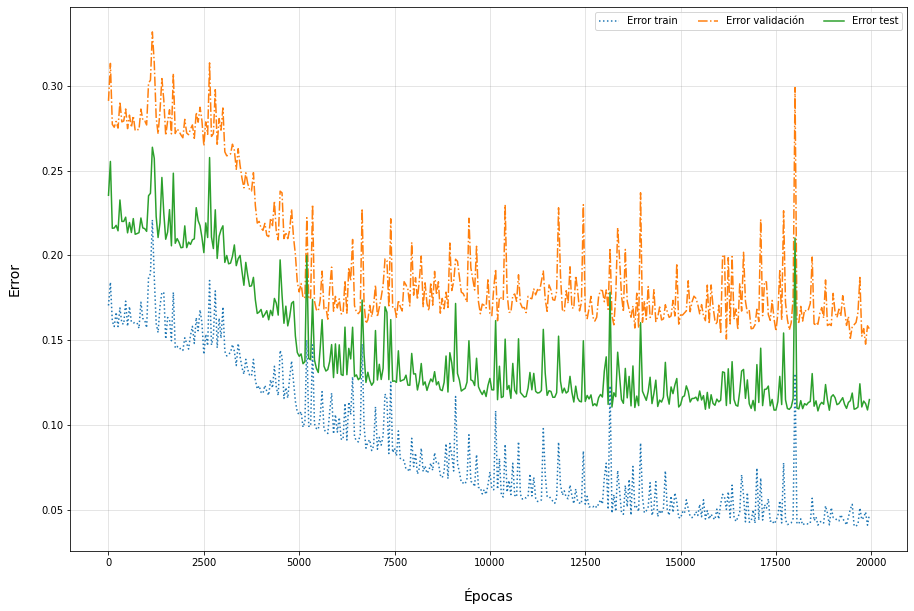

In [19]:
ejercicio_tres()

En los tres gráficos, se puede observar que el error es relativamente alto en todas las curvas durante los primeros entrenamientos y luego disminuye (de forma más pronunciada en el caso 95 train-5 test). Esto podría ser ya que se le provee más datos de entrenamiento para ese momento.

Las curvas de error de test parecen ser similares entre sí. Las diferencias más notorias radican entre los pares de curvas de train y test, donde se ven más separadas en el caso 50 train-50 test y en las curvas de validación, donde solo en el caso 95 train-5 test se encuentra por debajo de las demás curvas. Todo parecería indicar que separar un 5% del dataset para validación no sería suficiente para validar nuestro modelo y separar un 50% sería más propenso a un sobreajuste.

---

4. Regularización: Vamos a usar regularización por penalización, el weight-decay. Hay que tener cuidado con los nombres de los parámetros en este caso. El parámetro que nosotros llamamos gamma en la teoría corresponde en MLP de sklearn al parámetro alpha, mientras que nosotros usamos alfa para el momentum en general. Para activarlo tenemos que usar:

```python
gamma=0.00001
regr = MLPRegressor(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=gamma, batch_size=1, learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)
```

En este tipo de regularización no se usa un conjunto de validación, asi que hay que modificar la función que crearon para evaluar el entrenamiento de las redes, para que en lugar del error sobre el conjunto de validación, nos devuelva la suma de los valores absolutos o de los valores al cuadrado de todos los pesos de la red en la epoca correspondiente, y todo el resto igual que antes.

Una vez implementado, aplíquelo al dataset Sunspots (ssp). Busque el valor de gamma adecuado para conseguir un equilibrio entre evitar el sobreajuste y hacer el modelo demasiado rígido (el valor de gamma se debe variar en varios órdenes de magnitud, por ejemplo empezar en 10^-6 e ir hasta 10^0 (1) de a un orden cada vez). En este caso todos los registros del archivo .data se deben usar para el entrenamiento, ya que la regularización se realiza con la penalización a los pesos grandes. 
Los otros parámetros se pueden tomar: learning rate 0.05, momentum 0.3, 4000 evaluaciones del entrenamiento, cada una de 20 épocas, 6 neuronas en la capa intermedia.

Entregue curvas de los tres errores (entrenamiento y test en una figura, penalización en otra figura) para el valor de gamma elegido, y para algún otro valor en que haya observado sobreajuste. Comente los resultados.

In [9]:
from math import inf

def ej_cuatro_dfs(col_names):

  df_train = pd.read_csv("datasets/ssp.data", header=None, names = col_names)
  X_train, y_train = df_train[col_names[:-1]], df_train[col_names[-1]]

  df_test = pd.read_csv("datasets/ssp.test", header=None, names = col_names)
  X_test, y_test = df_test[col_names[:-1]], df_test[col_names[-1]]

  return X_train, y_train, X_test, y_test

def ejercicio_cuatro():
  col_names = list(range(12)) + ['Value']
  X_train, y_train, X_test, y_test = ej_cuatro_dfs(col_names)

  N2 = 6
  evaluaciones = 4000
  epocas = 20
  eta = 0.05   # learning rate
  alfa = 0.3   # momentum

  tabla = []
  best_test_error = inf
  gamma_values = [10 ** i for i in range(-6, 1)] # weight-decays

  for gamma in gamma_values:
    mlp = MLPGamma(gamma, epocas, eta, alfa, N2)

    errores = []
    weights = []

    for i in range(evaluaciones):
      mlp.regr.fit(X_train, y_train)

      weights_sum = sum(map(lambda a : np.sum(np.power(a, 2)), mlp.regr.coefs_))

      predict_train = mlp.regr.predict(X_train)
      predict_test = mlp.regr.predict(X_test)

      actual_error_train = sk.metrics.mean_squared_error(y_train, predict_train)
      actual_error_test = sk.metrics.mean_squared_error(y_test, predict_test)

      errores.append([actual_error_train, i * epocas, "Train error"])
      errores.append([actual_error_test, i * epocas, "Test error"])
      weights.append([i * epocas, weights_sum])
    
    if actual_error_test < best_test_error:
      best_test_error = actual_error_test
      best_gamma = gamma
      best_sum_weight = weights_sum
      best_df_errores = pd.DataFrame(errores, columns=['Error', 'Épocas', 'Clase'])
      best_df_weights = pd.DataFrame(weights, columns=['Épocas', 'Pesos'])

    tabla.append([gamma, actual_error_train, actual_error_test])

  df_tabla = pd.DataFrame(tabla, columns = ["Gamma", "Train error", "Test error"])

  return df_tabla, best_test_error, best_gamma, best_sum_weight, best_df_errores, best_df_weights

In [10]:
df_tabla, best_test_error, best_gamma, best_sum_weight, best_df_errores, best_df_weights = ejercicio_cuatro()

In [11]:
print(f"Mejor gamma: {best_gamma} con error de test {best_test_error} y suma de pesos al cuadrado {best_sum_weight}.")
df_tabla

Mejor gamma: 1e-06 con error de test 0.005389221683790859 y suma de pesos al cuadrado 58.39301267322536.


,Gamma,Train error,Test error
0,0.000001,0.004751,0.005389
1,0.000010,0.006019,0.006109
2,0.000100,0.005092,0.005486
3,0.001000,0.008359,0.007865
4,0.010000,0.024225,0.022402
5,0.100000,0.044023,0.038362
6,1.000000,0.042573,0.038101


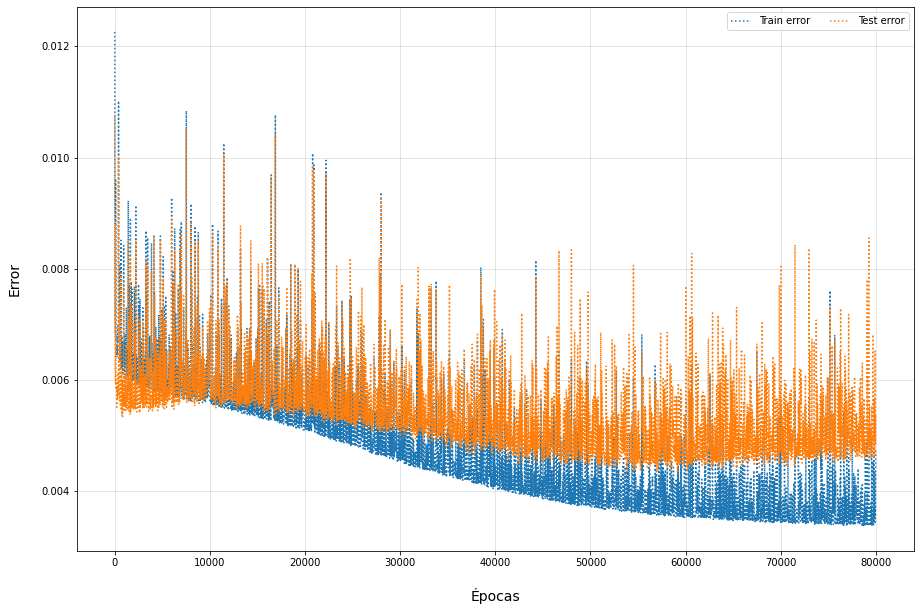

In [15]:
graph_errores(best_df_errores, referencia='Épocas')

In [18]:
def graph_weights(df, referencia):
  fig, ax = plt.subplots(figsize=(15, 10))
  ax.grid(which='both', color='grey', linewidth=1, linestyle='-', alpha=0.2)
  plt.plot(df[referencia], df['Pesos'], label="Weight", linestyle="-")
  plt.xlabel('Épocas', size=14, labelpad=15)
  plt.ylabel('Suma de los valores al cuadrado de los pesos en la red', size=14, labelpad=10)
  plt.legend()

  plt.show()

Mejor gamma: 1e-06


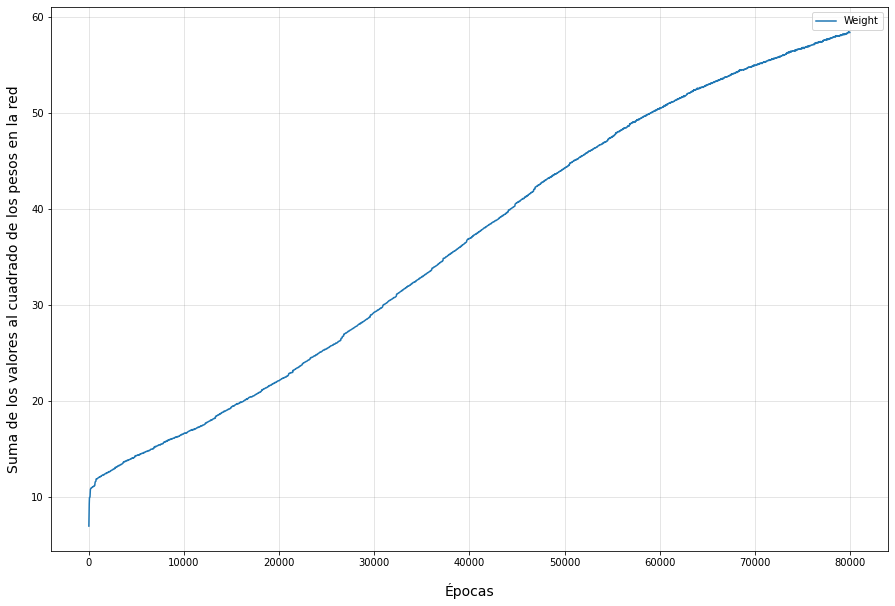

In [20]:
print(f"Mejor gamma: {best_gamma}")
graph_weights(best_df_weights, 'Épocas')

El mejor gamma de todos los aplicados fue 10^-6, cuyo error de test fue 0.005389 y de train fue 0.004751. Siendo valores tan estrechos, no parecería que hubo sobreajuste. En general, para ninguno de los valores de gamma se podría observar que hubo sobreajuste.

---

5. Dimensionalidad: 
 - Repita el punto 4 del Práctico 1, usando ahora redes con 6 unidades en la capa intermedia. Los otros parámetros hay que setearlos adecuadamente, usando como guía los casos anteriores. 
 - Genere una gráfica que incluya los resultados de redes y árboles.

Práctico 1. 4. Dimensionalidad:
 - Genere datasets con C = 0.78, n = 250 para el conjunto de entrenamiento y n = 10000 para el de test, variando esta vez el valor de d según la siguiente lista: 2, 4, 8, 16, 32. 
 - Para cada valor de d cree 20 conjuntos distintos de entrenamiento, y uno solo de test. 
 - Genere una gráfica del train y test error en función de d para el problema "paralelo" y el "diagonal" (todos en la misma gráfica). Discuta los resultados.

In [2]:
ej5_error_data = []

def entrenar_d(d, df_test, generador, gamma, epocas, evaluaciones, eta, alfa, N2):
  if generador == 'diagonal':
    df_train = GeneradorDFDiagonal(C=0.78, d=d, n=250).generar_clase()
  else:
    df_train = GeneradorDFParalelo(C=0.78, d=d, n=250).generar_clase()

  X_train, y_train = df_train[list(range(d))], df_train['Clase']
  X_test, y_test = df_test[list(range(d))], df_test['Clase']

  mlp = MLPGamma(gamma, epocas, eta, alfa, N2)

  for i in range(evaluaciones):
    mlp.clasif.fit(X_train, y_train)

  predict_train = mlp.clasif.predict(X_train)
  predict_test = mlp.clasif.predict(X_test)

  actual_error_train = sk.metrics.zero_one_loss(y_train, predict_train)
  actual_error_test = sk.metrics.zero_one_loss(y_test, predict_test)

  ej5_error_data.append([actual_error_train, d, "Redes - Train " + str(generador)])
  ej5_error_data.append([actual_error_test, d, "Redes - Test " + str(generador)])


def ejercicio_cinco():
  N2 = 6
  evaluaciones = 400
  epocas = 50
  eta = 0.01    # learning rate
  alfa = 0.9    # momentum
  gamma = 10 ** -6

  d_valores = [2, 4, 8, 16, 32]

  for d in d_valores:
    df_test_diag = GeneradorDFDiagonal(C=0.78, d=d, n=10000).generar_clase()
    df_test_paral = GeneradorDFParalelo(C=0.78, d=d, n=10000).generar_clase()

    for i in range(20):
      entrenar_d(d, df_test_diag, 'diagonal', gamma, epocas, evaluaciones, eta, alfa, N2)
      entrenar_d(d, df_test_paral, 'paralelo', gamma, epocas, evaluaciones, eta, alfa, N2)
  
  return pd.DataFrame(ej5_error_data, columns=['Error', 'd', 'Clase'])

In [3]:
errores_redes = ejercicio_cinco()

In [4]:
errores_redes.to_csv("datasets/ej5_errores_redes.csv", index = False)

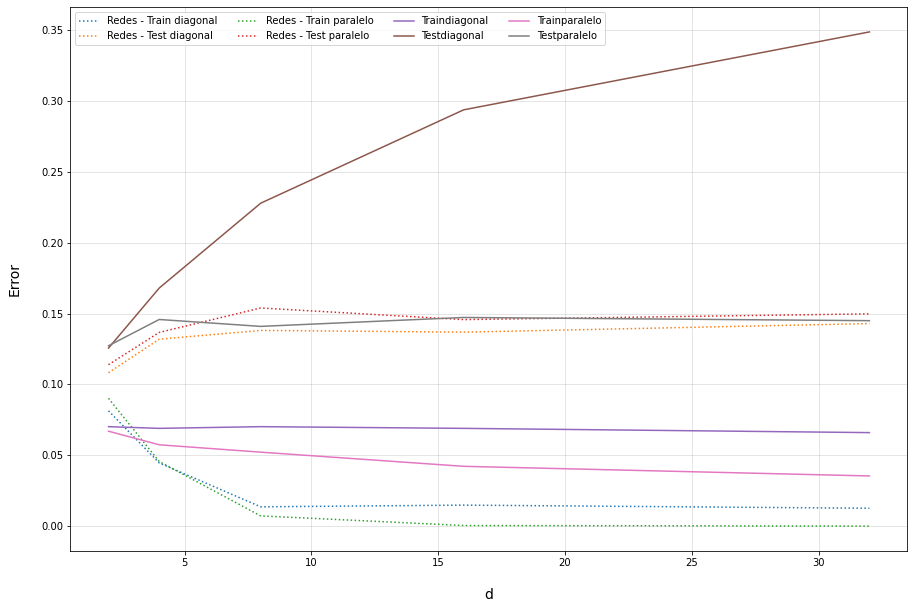

In [7]:
errores_redes = pd.read_csv("datasets/ej5_errores_redes.csv")
errores_arboles = pd.read_csv("datasets/ej5_errores_arboles.csv")

ej5_errores = pd.concat([errores_redes, errores_arboles])
graph_errores(ej5_errores, 'd')

El error sobre los conjuntos de entrenamiento de las redes es o se acerca mucho a cero a partir de las diez dimensiones.

Para el problema paralelo, los errores entre los conjuntos de test son muy similares. En cambio, para el problema diagonal, la diferencia es notable. Parecería que las redes son más eficientes para trabajar con grandes dimensiones si se trata de problemas como el de la diagonal.

Nota: la ejecución de este ejercicio tomó aproximadamente 607 minutos. Probablemente habría demorado menos si los entrenamientos de ambos problemas se hubiesen realizado en las mismas iteraciones.